# MNIST using PyTorch

* Use stepLR scheduler to decay the learning rates
* Use BatchNorm and Dropout of 0.1
* Max Params < 15K
* Expected Accuracy : 99.3


# Import Libraries

In [1]:
!nvidia-smi

Wed Feb 19 04:50:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# LR scheduler
from torch.optim.lr_scheduler import StepLR

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
    #  transforms.Resize((28, 28)),
    #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
      transforms.Grayscale(num_output_channels=3),
      transforms.RandomRotation(10),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),
      #transforms.ToPILImage(),
      transforms.Normalize((0.1307,) ,(0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
      # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
    #  transforms.Resize((28, 28)),
    #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
      transforms.ToTensor(),
      #transforms.ToPILImage(),
      transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([128, 1, 28, 28])
torch.Size([128])


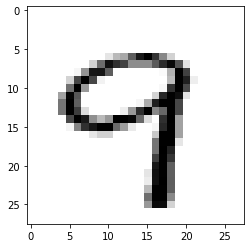

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
#train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [7]:
print(train_data.shape)
print(train_data[0].dtype)

torch.Size([60000, 28, 28])
torch.uint8


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

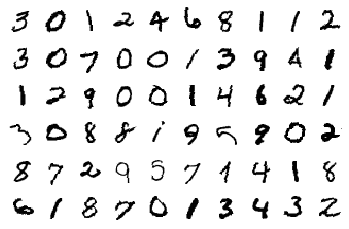

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.ReLU(),
            #nn.Dropout(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(64),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
           Dropout-3           [-1, 16, 26, 26]               0
              ReLU-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
            Conv2d-8           [-1, 16, 22, 22]           2,304
       BatchNorm2d-9           [-1, 16, 22, 22]              32
             ReLU-10           [-1, 16, 22, 22]               0
        MaxPool2d-11           [-1, 16, 11, 11]               0
           Conv2d-12           [-1, 16, 11, 11]             256
      BatchNorm2d-13           [-1, 16, 11, 11]              32
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [17]:
device

device(type='cuda')

In [18]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# gamma = decaying factor
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    # Decay Learning Rate
    scheduler.step()

    print("EPOCH:", epoch, 'LR:', scheduler.get_lr())

    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 LR: [0.01]


Loss=0.09365753084421158 Batch_id=468 Accuracy=92.06: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9815/10000 (98.15%)

EPOCH: 1 LR: [0.01]


Loss=0.055052679032087326 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:25<00:00, 18.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9872/10000 (98.72%)

EPOCH: 2 LR: [0.01]


Loss=0.05336708948016167 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:24<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9854/10000 (98.54%)

EPOCH: 3 LR: [0.01]


Loss=0.04869574308395386 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9907/10000 (99.07%)

EPOCH: 4 LR: [0.01]


Loss=0.03365284577012062 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9885/10000 (98.85%)

EPOCH: 5 LR: [0.0001]


Loss=0.012832040898501873 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)

EPOCH: 6 LR: [0.001]


Loss=0.031116610392928123 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:25<00:00, 18.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)

EPOCH: 7 LR: [0.001]


Loss=0.013558114878833294 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:25<00:00, 18.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9943/10000 (99.43%)

EPOCH: 8 LR: [0.001]


Loss=0.12020217627286911 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:24<00:00, 18.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 9 LR: [0.001]


Loss=0.023538192734122276 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 10 LR: [0.001]


Loss=0.03891940787434578 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:25<00:00, 18.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 11 LR: [1e-05]


Loss=0.01648882031440735 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 12 LR: [0.0001]


Loss=0.0031220316886901855 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 13 LR: [0.0001]


Loss=0.018752446398139 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 14 LR: [0.0001]


Loss=0.005183771252632141 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:23<00:00, 25.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 15 LR: [0.0001]


Loss=0.026380738243460655 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 16 LR: [0.0001]


Loss=0.14210475981235504 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 17 LR: [1.0000000000000002e-06]


Loss=0.029116680845618248 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:23<00:00, 19.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 18 LR: [1e-05]


Loss=0.006521528121083975 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 19 LR: [1e-05]


Loss=0.04218592122197151 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]



Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

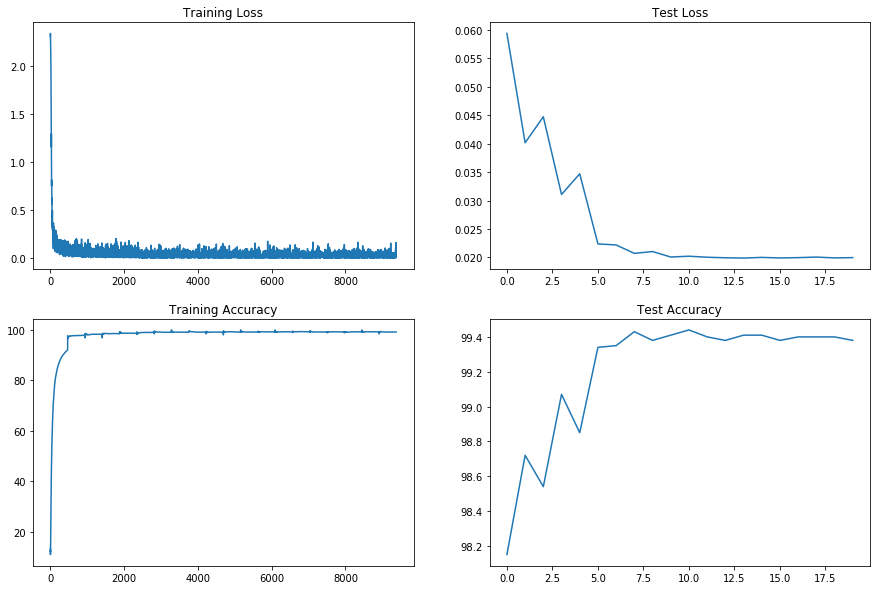

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")